### Manipulator PID control

In [1]:
import numpy as np
np.set_printoptions(precision=2)
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
from mujoco_parser import MuJoCoParserClass
from pid           import PID_ControllerClass
print ("Done.")

Done.


### Parse manipulator

Creating offscreen glfw


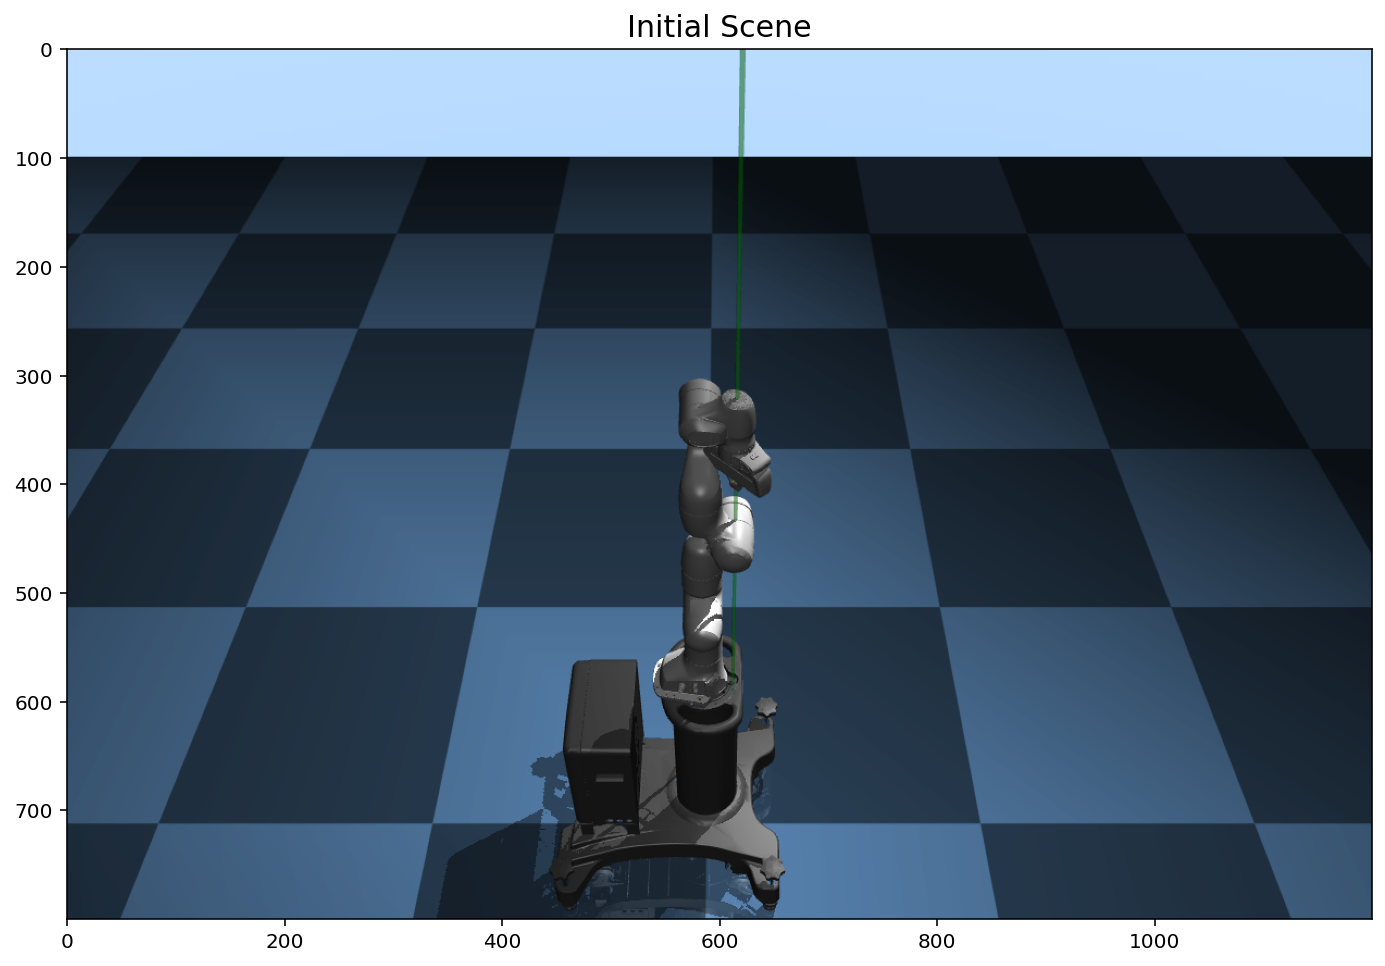

In [2]:
env = MuJoCoParserClass(name='Panda',rel_path='../asset/panda/franka_panda.xml',VERBOSE=False)
PID = PID_ControllerClass(
    name = 'PID',dim = env.n_rev_joint,
    k_p = 500.0, k_i = 0.0, k_d = 100.0, # <= D gain is super important
    out_min = env.torque_range[env.rev_joint_idxs,0],
    out_max = env.torque_range[env.rev_joint_idxs,1],
    ANTIWU  = True)
env.plot_scene(figsize=(12,8),render_w=1200,render_h=800,title_str='Initial Scene',title_fs=15)

In [3]:
q_des = np.array([0,0,0,-90,0,90,0])*np.pi/180.0 # desired position

env.init_viewer(TERMINATE_GLFW=True,window_width=0.5,window_height=0.5)
env.set_max_sec(max_sec=10.0)
env.reset() # reset env
PID.reset() # reset PID

q_curr_list  = np.zeros(shape=(env.max_tick,PID.dim))
q_des_list   = np.zeros(shape=(env.max_tick,PID.dim))
sec_sim_list = np.zeros(shape=(env.max_tick))
torque_list  = np.zeros(shape=(env.max_tick,PID.dim))
while env.IS_ALIVE():
    # Control revolute joint
    PID.update(x_trgt=q_des)
    PID.update(t_curr=env.get_sec_sim(),x_curr=env.get_q_rev(),VERBOSE=False)
    torque = PID.out()
    
    # Step and render
    env.add_marker(pos=env.get_p_body(body_name='panda_eef'),radius=0.03,color=np.array([0,1,0,0.5]),label='EE')
    env.step_and_render(torque=torque,render_speedup=2.0)
    env.print(print_every_sec=1.0,VERBOSE=1)
    
    # Append current and target joint positions
    q_curr_list[env.tick-1,:],sec_sim_list[env.tick-1] = env.get_q_rev(),env.get_sec_sim()
    q_des_list[env.tick-1,:],torque_list[env.tick-1,:] = q_des,torque
    
print ("Done.")

Creating window glfw
tick:[1/5001], sec_wall:[0.149]sec, sec_sim:[0.002]sec
tick:[501/5001], sec_wall:[0.507]sec, sec_sim:[1.002]sec
tick:[1001/5001], sec_wall:[0.992]sec, sec_sim:[2.002]sec
tick:[1501/5001], sec_wall:[1.499]sec, sec_sim:[3.002]sec
tick:[2001/5001], sec_wall:[2.005]sec, sec_sim:[4.002]sec
tick:[2501/5001], sec_wall:[2.509]sec, sec_sim:[5.002]sec
tick:[3001/5001], sec_wall:[3.012]sec, sec_sim:[6.002]sec
tick:[3501/5001], sec_wall:[3.495]sec, sec_sim:[7.002]sec
tick:[4001/5001], sec_wall:[3.999]sec, sec_sim:[8.002]sec
tick:[4501/5001], sec_wall:[4.505]sec, sec_sim:[9.002]sec
tick:[5001/5001], sec_wall:[5.009]sec, sec_sim:[10.002]sec
Done.


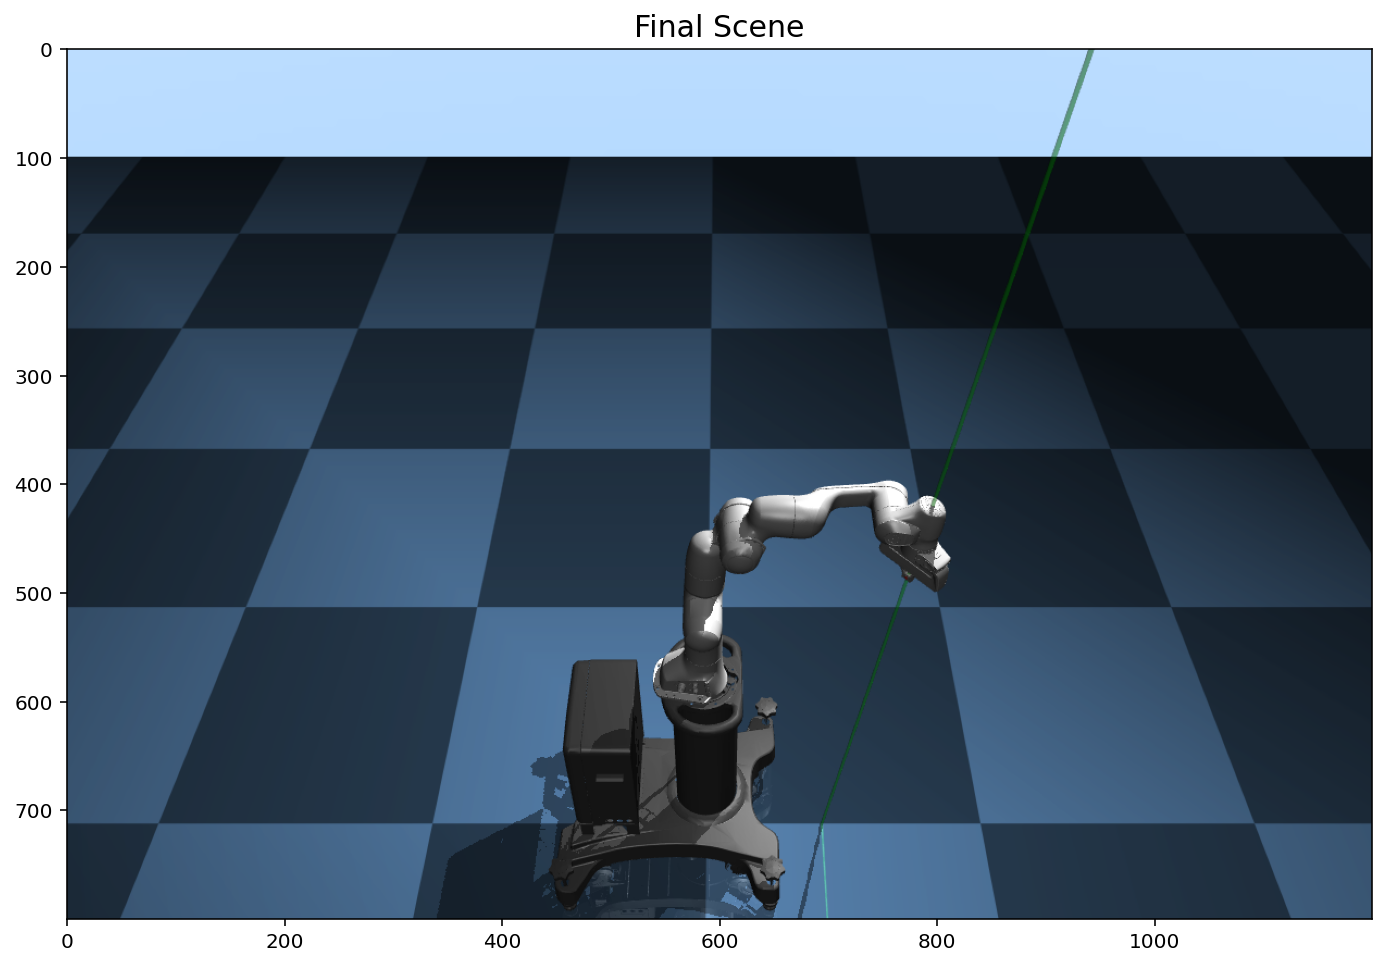

In [4]:
env.plot_scene(figsize=(12,8),render_w=1200,render_h=800,title_str='Final Scene',title_fs=15)

In [5]:
env.terminate_viewer() # terminate viewer

### Plot joint tracking results

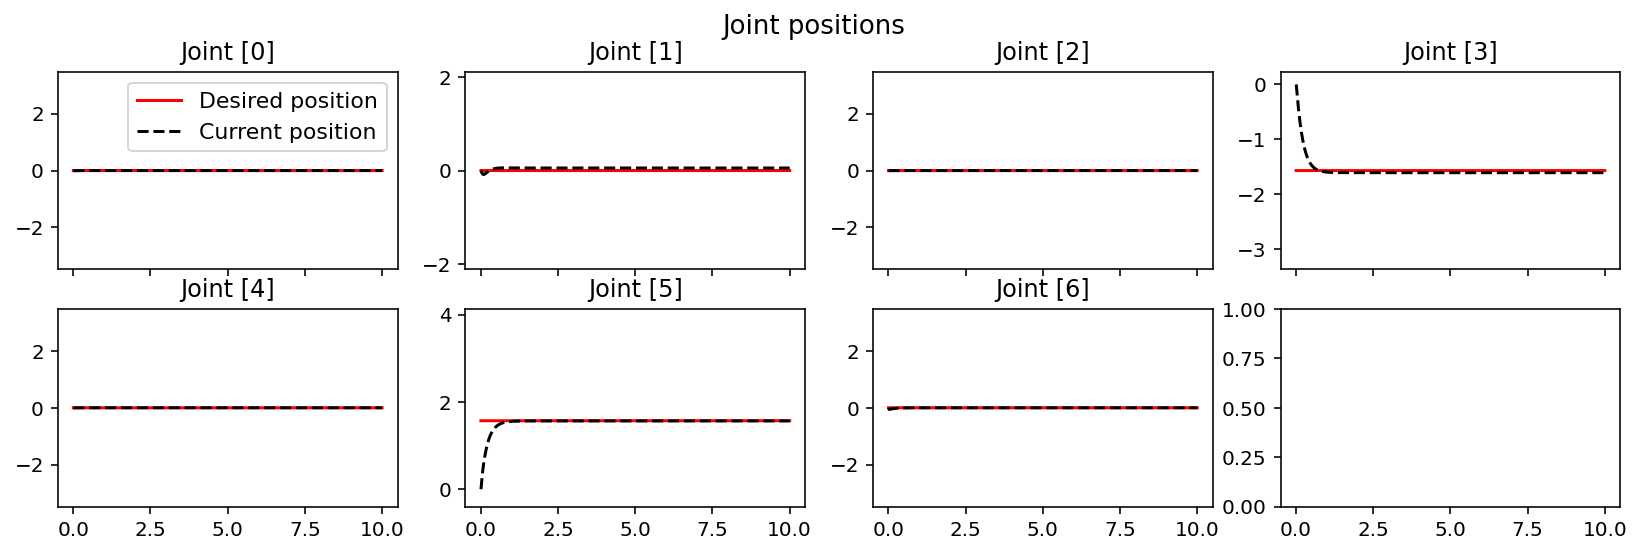

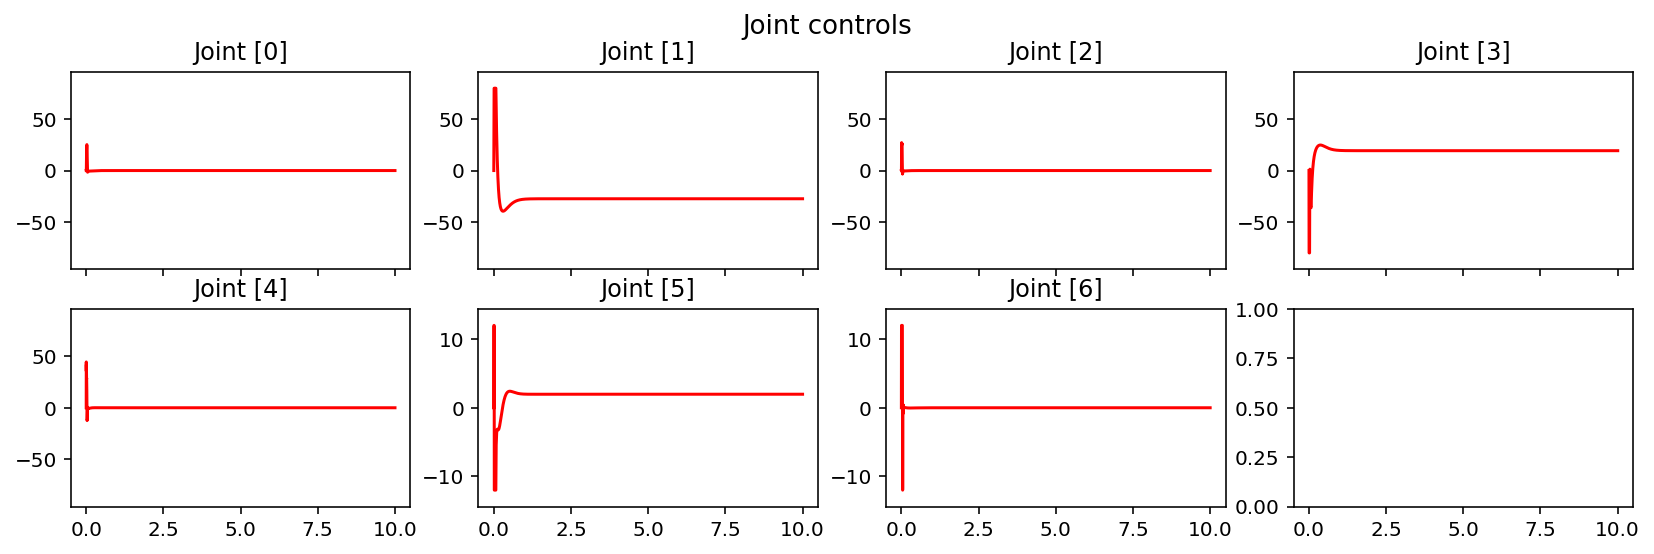

In [6]:
# Plot target and current joint position
fig,axs = plt.subplots(nrows=2,ncols=4,sharex=True,sharey=False,figsize=(14,4))
fig.suptitle("Joint positions", fontsize=13)
for a_idx,ax in enumerate(axs.ravel()):
    if (a_idx >= PID.dim): continue
    ax.plot(sec_sim_list,q_des_list[:,a_idx],'-',color='r',label='Desired position')
    ax.plot(sec_sim_list,q_curr_list[:,a_idx],'--',color='k',label='Current position')
    qmarg = 0.1*(env.joint_range[a_idx,1]-env.joint_range[a_idx,0])
    ax.set_ylim(bottom=env.joint_range[a_idx,0]-qmarg,top=env.joint_range[a_idx,1]+qmarg)
    ax.set_title('Joint [%d]'%(a_idx))
    if a_idx == 0: ax.legend(fontsize=11)
plt.show()
# Plot control output
fig,axs = plt.subplots(nrows=2,ncols=4,sharex=True,sharey=False,figsize=(14,4))
fig.suptitle("Joint controls", fontsize=13)
for a_idx,ax in enumerate(axs.ravel()):
    if (a_idx >= PID.dim): continue
    ax.plot(sec_sim_list,torque_list[:,a_idx],color='r')
    tmarg = 0.1*(env.torque_range[a_idx,1]-env.torque_range[a_idx,0])
    ax.set_ylim(bottom=env.torque_range[a_idx,0]-tmarg,top=env.torque_range[a_idx,1]+tmarg)
    ax.set_title('Joint [%d]'%(a_idx))
plt.show()